In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
from pyinstrument import Profiler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import os
sys.path.append(os.path.dirname(os.getcwd()))
from bart_playground import *

import bartz

## 4 Special Moves

In [2]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
abalone = fetch_ucirepo(id=1) 
  
# data (as pandas dataframes) 
X = abalone.data.features 
y = abalone.data.targets 

# variable information 
print(abalone.variables)

             name     role         type demographic  \
0             Sex  Feature  Categorical        None   
1          Length  Feature   Continuous        None   
2        Diameter  Feature   Continuous        None   
3          Height  Feature   Continuous        None   
4    Whole_weight  Feature   Continuous        None   
5  Shucked_weight  Feature   Continuous        None   
6  Viscera_weight  Feature   Continuous        None   
7    Shell_weight  Feature   Continuous        None   
8           Rings   Target      Integer        None   

                   description  units missing_values  
0         M, F, and I (infant)   None             no  
1    Longest shell measurement     mm             no  
2      perpendicular to length     mm             no  
3           with meat in shell     mm             no  
4                whole abalone  grams             no  
5               weight of meat  grams             no  
6  gut weight (after bleeding)  grams             no  
7        

In [3]:
if 'Sex' in X.columns:
    print("\nSex value counts:")
    print(X['Sex'].value_counts())


Sex value counts:
Sex
M    1528
I    1342
F    1307
Name: count, dtype: int64


In [4]:
X = X.drop(columns=['Sex'])
X

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550
...,...,...,...,...,...,...,...
4172,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490
4173,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605
4174,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080
4175,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960


In [5]:
X = X.values.astype(float)
y = np.array(y).reshape(-1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [6]:
proposal_probs = {"grow" : 0.5, "prune" : 0.5}
#special_probs = {"birth": 0.5, "death": 0.5}
special_probs = {"birth": 0.25, "death": 0.25, "break": 0.25, "combine": 0.25}

In [7]:
n_trees_ini = 50
nskip = 5000
ndpost = 1000

bart = ChangeNumTreeBART(ndpost=ndpost, nskip=nskip, n_trees=n_trees_ini, 
                         proposal_probs=proposal_probs, special_probs = special_probs, 
                         theta_0_ini = n_trees_ini, theta_0_min = 2, theta_0_nskip_prop=0.4, theta_df = 100, 
                         tree_num_prior_type="generalized_poisson", min_eta=-0.999, eta_nskip_prop=0.3,
                         special_move_interval=5)
bart.fit(X_train, y_train)

Iterations: 100%|██████████| 6000/6000 [02:40<00:00, 37.34it/s]


In [8]:
bart.trace[-1].n_trees

22

In [9]:
bart.trace[-1].global_params

{'eps_sigma2': array([0.00533764]), 'ntree_theta': 2.918326377884387}

In [10]:
# Extract the n_trees value for each instance
n_trees_list = [instance.n_trees for instance in bart.trace]
np.mean(n_trees_list)

22.0

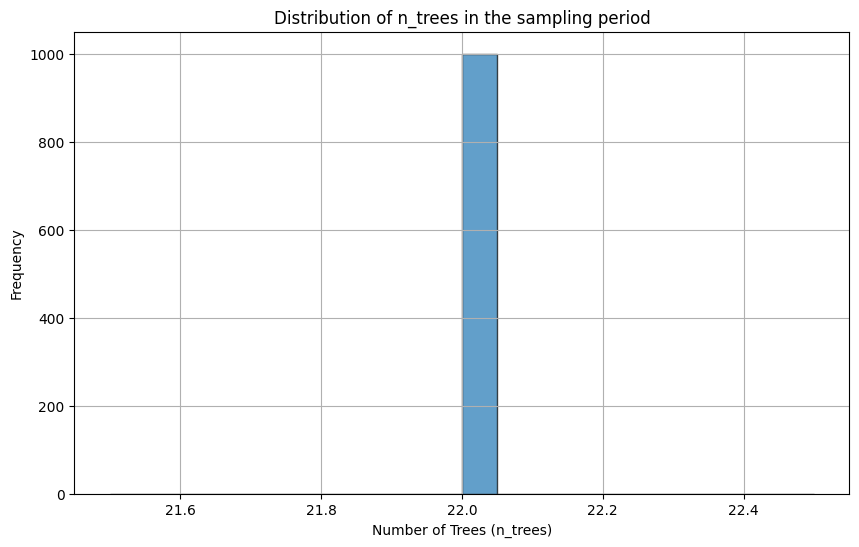

In [11]:
# Create a histogram with bins for each integer value
plt.figure(figsize=(10, 6))
plt.hist(n_trees_list, bins=20, edgecolor='k', alpha=0.7)
plt.title('Distribution of n_trees in the sampling period')
plt.xlabel('Number of Trees (n_trees)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

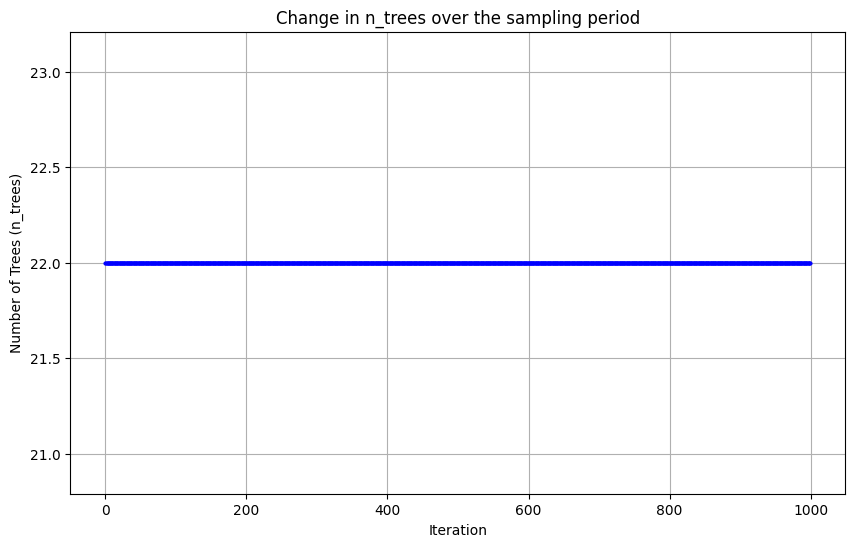

In [12]:
# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(
    range(len(n_trees_list)), 
    n_trees_list, 
    marker='o', 
    markersize=2,  # Adjust marker size
    linestyle='-', 
    linewidth=0.5,  # Adjust line width
    color='b'
)
plt.title('Change in n_trees over the sampling period')
plt.xlabel('Iteration')
plt.ylabel('Number of Trees (n_trees)')
plt.grid(True)
plt.show()

In [13]:
bart.sampler.tree_num_prior

In [14]:
# Extract ntree_theta from global_params for each trace
ntree_theta_list = [trace.global_params['ntree_theta'] for trace in bart.trace]
np.mean(ntree_theta_list)

2.780498285124393

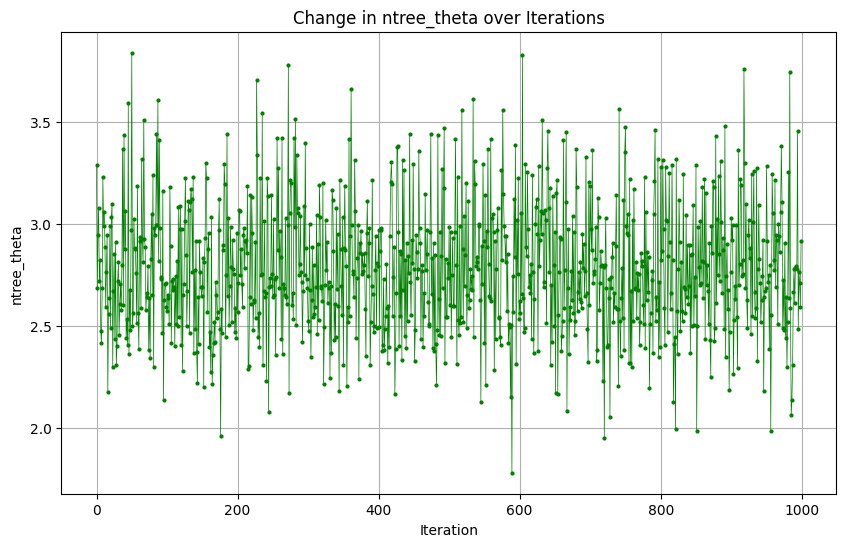

In [15]:
# Plot ntree_theta over iterations
plt.figure(figsize=(10, 6))
plt.plot(range(len(ntree_theta_list)), ntree_theta_list, marker='o', markersize=2, linestyle='-', linewidth=0.5, color='g')
plt.title('Change in ntree_theta over Iterations')
plt.xlabel('Iteration')
plt.ylabel('ntree_theta')
plt.grid(True)
plt.show()

In [16]:
ntree = bart.trace[-1].n_trees
rf = RandomForestRegressor(n_estimators=ntree)
lr = LinearRegression()
rf.fit(X_train, y_train)
lr.fit(X_train, y_train)

btz = bartz.BART.gbart(np.transpose(X_train), y_train, ntree=ntree, ndpost=ndpost, nskip=200)
btpred_all = btz.predict(np.transpose(X_test))
btpred = np.mean(np.array(btpred_all), axis=0)

INFO:2025-06-26 02:18:23,721:jax._src.xla_bridge:927: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2025-06-26 02:18:23,725:jax._src.xla_bridge:927: Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.


Iteration  100/1200 P_grow=0.55 P_prune=0.45 A_grow=0.08 A_prune=0.10 (burnin)
Iteration  200/1200 P_grow=0.36 P_prune=0.64 A_grow=0.38 A_prune=0.14 (burnin)
Iteration  300/1200 P_grow=0.55 P_prune=0.45 A_grow=0.08 A_prune=0.00
Iteration  400/1200 P_grow=0.68 P_prune=0.32 A_grow=0.07 A_prune=0.14
Iteration  500/1200 P_grow=0.41 P_prune=0.59 A_grow=0.00 A_prune=0.15
Iteration  600/1200 P_grow=0.59 P_prune=0.41 A_grow=0.00 A_prune=0.00
Iteration  700/1200 P_grow=0.55 P_prune=0.45 A_grow=0.00 A_prune=0.00
Iteration  800/1200 P_grow=0.55 P_prune=0.45 A_grow=0.00 A_prune=0.10
Iteration  900/1200 P_grow=0.55 P_prune=0.45 A_grow=0.08 A_prune=0.10
Iteration 1000/1200 P_grow=0.45 P_prune=0.55 A_grow=0.10 A_prune=0.08
Iteration 1100/1200 P_grow=0.59 P_prune=0.41 A_grow=0.08 A_prune=0.11
Iteration 1200/1200 P_grow=0.50 P_prune=0.50 A_grow=0.18 A_prune=0.00


In [17]:
bart_default = DefaultBART(ndpost=ndpost, nskip=200, n_trees=ntree, proposal_probs=proposal_probs)
bart_default.fit(X_train, y_train)

Iterations: 100%|██████████| 1200/1200 [00:20<00:00, 57.38it/s]


In [18]:
models = {"bart" : bart, 
          "rf" : rf, 
          "lr" : lr,
          "btz" : btz,
          "bart_default" : bart_default}
results = {}
for model_name, model in models.items():
    if model_name == "btz":
        results[model_name] = mean_squared_error(y_test, btpred)
    else:
        results[model_name] = mean_squared_error(y_test, model.predict(X_test))
results

{'bart': 5.259508327289274,
 'rf': 5.040266519039899,
 'lr': 4.816317561210926,
 'btz': 5.088037221359948,
 'bart_default': 4.974014439910895}

In [19]:
if all([(bart.sampler.trace[-1].trees[i].evaluate() == bart.sampler.trace[-1].trees[i].evaluate(X_train)).all()
            for i in range(bart.sampler.trace[-1].n_trees)]):
    print("True")
else:
    print("False")

True


In [20]:
np.allclose(bart.sampler.trace[-1].evaluate(X_train), bart.sampler.trace[-1].evaluate(), atol=1e-10, rtol=1e-12)

True

In [21]:
print(f'Birth move count: {len(bart.sampler.birth_mh_ratios)}; mh median: {np.median(bart.sampler.birth_mh_ratios)}')

Birth move count: 1434; mh median: nan


In [22]:
print(f'Death move count: {len(bart.sampler.death_mh_ratios)}; mh median: {np.median(bart.sampler.death_mh_ratios)}')

Death move count: 91; mh median: nan


In [23]:
print(f'Break move count: {len(bart.sampler.break_mh_ratios)}; mh median: {np.median(bart.sampler.break_mh_ratios)}')

Break move count: 1063; mh median: nan


In [24]:
print(f'Combine move count: {len(bart.sampler.combine_mh_ratios)}; mh median: {np.median(bart.sampler.combine_mh_ratios)}')

Combine move count: 1048; mh median: nan


In [25]:
print(bart.sampler.accepted_moves)

{'birth': 25, 'death': 24, 'break': 93, 'combine': 122}


In [26]:
bart.trace[-1].trees

[Tree(vars=[ 4 -1 -1 -2 -2 -2 -2 -2], thresholds=[0.432   nan   nan   nan   nan   nan   nan   nan], leaf_vals=[       nan 0.01976278 0.0073347         nan        nan        nan
         nan        nan], n_vals=[3132 2007 1125   -2   -2   -2   -2   -2]),
 Tree(vars=[ 4 -1  6 -2 -2  4 -1 -2 -2 -2 -2  3 -1 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -1
  -1 -2 -2 -2 -2 -2 -2 -2], thresholds=[0.21365     nan 0.565       nan     nan 0.3125      nan     nan     nan
      nan     nan 0.714       nan     nan     nan     nan     nan     nan
      nan     nan     nan     nan     nan     nan     nan     nan     nan
      nan     nan     nan     nan     nan], leaf_vals=[        nan -0.03181992 -0.01513358         nan         nan         nan
  -0.04909075         nan         nan         nan         nan         nan
  -0.05382337         nan         nan         nan         nan         nan
          nan         nan         nan         nan         nan -0.0299915
   0.01727006         nan         nan         nan     